**Model Evaluation – Forecasting Metrics**

After fitting ARIMA or SARIMA, we evaluate how well the model predicts unseen data using **time-aware train/test split** and proper error metrics.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

**Dataset:**

Air passengers data 

In [4]:
data = pd.read_csv('/kaggle/input/airpassengers-dataframe/AirPassengers.csv')

In [5]:
data

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,112,118,132,129,121,135,148,148,136,119,104,118
1,115,126,141,135,125,149,170,170,158,133,114,140
2,145,150,178,163,172,178,199,199,184,162,146,166
3,171,180,193,181,183,218,230,242,209,191,172,194
4,196,196,236,235,229,243,264,272,237,211,180,201
5,204,188,235,227,234,264,302,293,259,229,203,229
6,242,233,267,269,270,315,364,347,312,274,237,278
7,284,277,317,313,318,374,413,405,355,306,271,306
8,315,301,356,348,355,422,465,467,404,347,305,336
9,340,318,362,348,363,435,491,505,404,359,310,337


Adding the year manually because that data is missing in the actually data

In [6]:
data['Year'] = list(range(1949, 1949 + len(data)))

In [7]:
data.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
0,112,118,132,129,121,135,148,148,136,119,104,118,1949
1,115,126,141,135,125,149,170,170,158,133,114,140,1950
2,145,150,178,163,172,178,199,199,184,162,146,166,1951
3,171,180,193,181,183,218,230,242,209,191,172,194,1952
4,196,196,236,235,229,243,264,272,237,211,180,201,1953


changing the format of the data for proper analysis

In [8]:
df = data.melt(id_vars='Year', var_name='Month', value_name='Passengers')

In [9]:
df.head()

,Year,Month,Passengers
0,1949,Jan,112
1,1950,Jan,115
2,1951,Jan,145
3,1952,Jan,171
4,1953,Jan,196


conversion of year and month to proper data because timeseries works better on the datatime format data

In [10]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%b')
df.set_index('Date', inplace=True)
df = df[['Passengers']]

In [11]:
df.head()

,Passengers
Date,
1949-01-01,112
1950-01-01,115
1951-01-01,145
1952-01-01,171
1953-01-01,196


In [12]:
df = df.sort_index()

**Visualize Original Series**

We plot the AirPassengers dataset to inspect its trend.

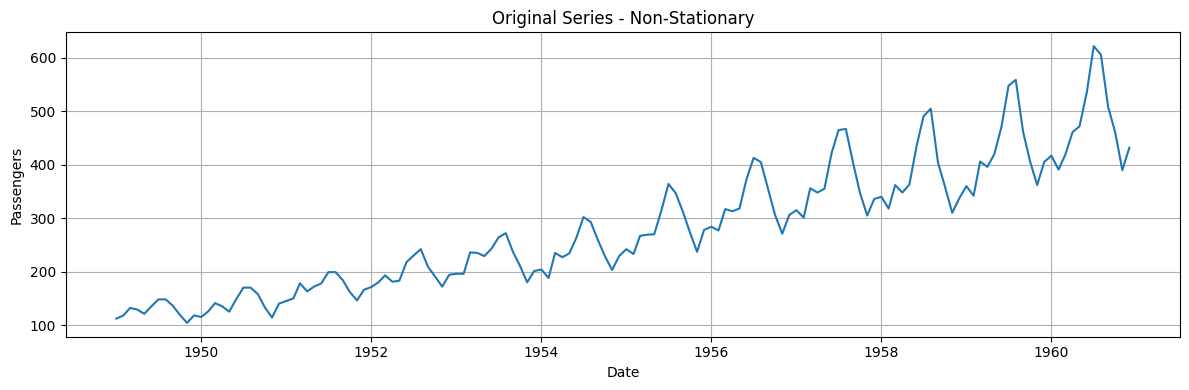

In [13]:
# Ensure Date index is sorted

plt.figure(figsize=(12, 4))
plt.plot(df['Passengers'])
plt.title("Original Series - Non-Stationary")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.grid(True)
plt.tight_layout()
plt.show()

**Train-Test Split**

We split the time series so that:
- **Training** = all data except last 12 months
- **Testing** = last 12 months

This preserves the time order (no random shuffling).

In [18]:
train = df[:-12]
test = df[-12:]

**Fit SARIMA Model (p,d,q)(P,D,Q,s)**

*SARIMA Parameters:*
Non-seasonal (ARIMA part):

- p=1: lag of value

- d=1: differencing for trend

- q=1: lag of error

Seasonal:

- P=1: 12-month seasonal AR term

- D=1: seasonal differencing

- Q=1: seasonal MA term

- s=12: monthly data with yearly cycle

This handles both trend and annual seasonality.

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA — s=12 for monthly seasonality
model_sarima = SARIMAX(train['Passengers'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12))
result_sarima = model_sarima.fit()

print(result_sarima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -445.700
Date:                            Wed, 30 Jul 2025   AIC                            901.399
Time:                                    05:35:39   BIC                            915.295
Sample:                                01-01-1949   HQIC                           907.042
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4976      0.312     -1.596      0.110      -1.109       0.113
ma.L1          0.2583      0.335   

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Forecast on Test Period**

In [24]:
prediction = result_sarima.get_prediction(start=test.index[0], end=test.index[-1])
forecast = prediction.predicted_mean

**Evaluation Metrics **

We use 3 core metrics to evaluate forecasting error



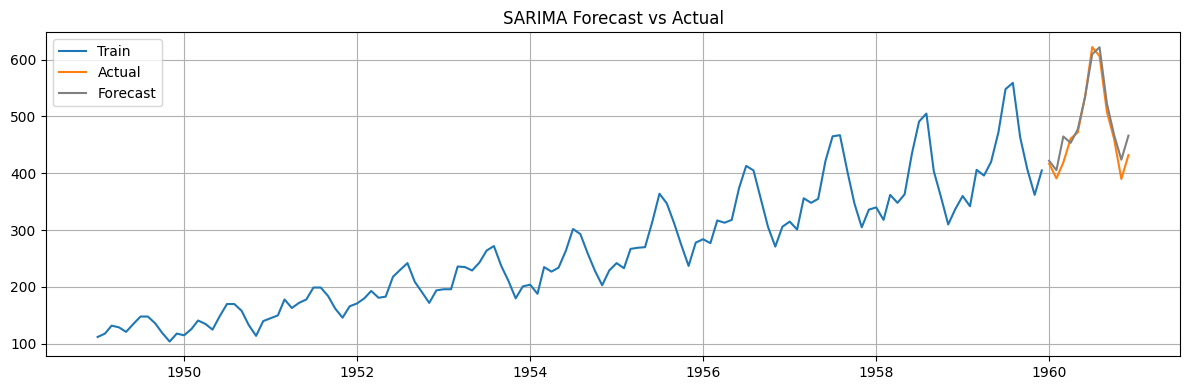

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(train.index, train['Passengers'], label='Train')
plt.plot(test.index, test['Passengers'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='grey')
plt.title("SARIMA Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['Passengers'], forecast)
rmse = np.sqrt(mean_squared_error(test['Passengers'], forecast))
mape = np.mean(np.abs((test['Passengers'] - forecast) / test['Passengers'])) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  16.32
RMSE: 21.19
MAPE: 3.68%


Choose your metric based on:

Business goals, 
Data scale, 
Error tolerance

This evaluation helps you understand whether your model is good enough for deployment or needs further tuning.

